In [1]:
from wand.image import Image as WImage
from wand.color import Color

import datetime
import os
import locale
locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")

import pandas as pd
import numpy as np

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.graphics import renderPDF

from qrbill.bill import QRBill
from svglib.svglib import svg2rlg


In [2]:
def show_pdf(pdffilename):
    img = WImage(filename=pdffilename)
    bg = WImage(width=img.width, height=img.height, background=Color("white"))
    bg.composite(img,0,0)
    return bg

In [3]:
# Konstanten für den Lauf
rechnungsjahr = 2022
rechnungsdatum = datetime.date(2022, 11, 25)
rechnungsdatum_formatiert = rechnungsdatum.strftime("%d. %B %Y")
titelzeile = "Rechnung für Jahresbeitrag " + str(rechnungsjahr)
preis = {
    "Kollektiv": 150,
    "Einzel": 40,
    "Vorstand": 0
}

In [4]:
# Einlesen der Daten für den Lauf
liste_path = "C:/Users/jens-/Interessensgemeinschaft Records Management (IGRM)/Administration - Documents/2022/Finanzen/"
liste_filename = "2022-11-24 Aktive Mitglieder zum Rechnungsversand.xlsx"
liste = pd.read_excel(liste_path + liste_filename)   
rm_quote = lambda x: x.replace('"', '')
liste = liste.rename(columns=rm_quote)
liste = liste.set_index("ID")

# Generate Invoice

In [5]:
def gen_ref_number(mitglied, jahr):
    if mitglied < 1000 or mitglied > 9999:
        raise Exception ("Ungültige Mitgliedsnummer")
    if jahr < 1000 or jahr > 9999:
        raise Exception ("Ungültiges Jahr")
    num_str = str(jahr) + str(mitglied) 
    prüfsumme = 98 - ( int(num_str + "271500") % 97 )
    prüf_str = "%02d" % prüfsumme
    return  "RF" + prüf_str + num_str

In [6]:
def generate_zahlteil(target_fn_svg, d):

    my_bill = QRBill(
            account = 'CH28 0900 0000 3046 8052 2',
            amount = f'{preis[d["Mitgliedstyp"]]:.2f}',
            currency="CHF",
            creditor={
                'name': 'Interessensgemeinschaft Records Management',
                #'street': 'Postfach', 
                #'house_num': '2551',
                'pcode': '3001', 
                'city': 'Bern', 
                'country': 'CH'
            },
            debtor={
                'name': d["Rechnungsadresse 1"],
                'street': d["Rechnungsadresse 2"], 
                'house_num': "",
                'pcode': str(d["PLZ"]), 
                'city': d["Ort"], 
                'country': 'CH'
            },
            #due_date="2019-12-14",
            ref_number = gen_ref_number(d["Mitgliedsnummer"], rechnungsjahr),
            extra_infos = "Mitgliedsnummer " + str(d["Mitgliedsnummer"]),
            language="de"
        )

    my_bill.as_svg(target_fn_svg)


In [7]:
def generate_pdf(target_fn, d):
    def header(c):
        to = c.beginText()
        to.setTextOrigin(2*cm, height-1.8*cm)
        to.setFont("Helvetica-Bold", 11)
        to.textLine("Interessengemeinschaft Records Management")
        to.setFont("Helvetica", 11)        to.textLine("3001 Bern")
        to.textLine("")
        to.textLine("www.igrm.ch")
        c.drawText(to)
        c.drawInlineImage('igrmlogo.jpg', 14*cm, height-3*cm, 4*cm, 1.5*cm)

    def zahlteil(c):    
        generate_zahlteil(target_fn + ".svg", d)
        drawing = svg2rlg(target_fn + ".svg")
        renderPDF.draw(drawing, c, 0, 0)
        os.remove(target_fn + ".svg")

    def adresse(c):
        to = c.beginText()
        to.setTextOrigin(2*cm, height-5.4*cm)
        to.setFont("Helvetica", 8)
        to.textLine("Interessengemeinschaft Records Management, 3001 Bern")
        to.textLine("")
        to.setFont("Helvetica", 11)
        to.textLine(d["Rechnungsadresse 1"])
        to.textLine(d["Rechnungsadresse 2"])
        to.textLine(d["Rechnungsadresse 3"])
        if pd.notna(d["Rechnungsadresse 4"]):
            to.textLine(d["Rechnungsadresse 4"])
        if pd.notna(d["Rechnungsadresse 5"]):
            to.textLine(d["Rechnungsadresse 5"])
        to.textLine("Versand per Email an: " + d["E-Mail Rechnungsversand"])
        c.drawText(to)
        p = c.beginPath()
        p.moveTo(2*cm, height-5.6*cm)
        p.lineTo(9.5*cm, height-5.6*cm)
        p.close()
        c.drawPath(p)

    def rechnung_kopf(c):
        to = c.beginText()
        to.setTextOrigin(2*cm, height-10*cm)
        to.setFont("Helvetica", 14)
        to.textLine(titelzeile)
        to.moveCursor(0,10)
        to.setFont("Helvetica", 11)
        to.textOut('Rechnungsdatum:')
        to.moveCursor(5*cm, 0)
        to.textLine(rechnungsdatum_formatiert)
        to.moveCursor(-5*cm, 0)
        to.textOut("Ansprechperson:")
        to.moveCursor(5*cm, 0)
        to.textOut(d["Ansprechperson"])
        to.moveCursor(5*cm, 0)
        to.textLine(d["Telefon"])
        if pd.notna(d["E-Mail"]):
            to.textLine(d["E-Mail"])
        to.moveCursor(-10*cm, 0)
        to.textOut("Typ Mitgliedschaft:")
        to.moveCursor(5*cm, 0)
        to.textLine(d["Mitgliedstyp"])
        to.moveCursor(-5*cm, 0)
        to.textOut("Mitgliedsnummer:")
        to.moveCursor(5*cm, 0)
        to.textLine(str(d["Mitgliedsnummer"]))
        to.moveCursor(-5*cm, 0)
        if pd.notna(d["Referenz"]):
            to.textOut("Ihre Referenz:")
            to.moveCursor(5*cm, 0)
            to.textLine(d["Referenz"])
            to.moveCursor(-5*cm, 0)
        if pd.notna(d["Kostenstelle"]):
            to.textOut("Ihre Kostenstelle:")
            to.moveCursor(5*cm, 0)
            to.textLine(str(d["Kostenstelle"]))
            c.drawText(to)

    def rechnung_tabelle(c):
        unten = height-16*cm
        links = 2*cm
        rechts = 17*cm
        zeilenhöhe = 0.8*cm
        sp1 = 1*cm
        sp2 = 7*cm
        sp3 = 9*cm
        sp4 = 12*cm
        xoffset = 5
        yoffset = 8

        p = c.beginPath()
        p.moveTo(links, unten)
        p.lineTo(rechts, unten)
        p.moveTo(links, 1 * zeilenhöhe + unten)
        p.lineTo(rechts, 1 * zeilenhöhe + unten)
        p.moveTo(links, 2 * zeilenhöhe + unten)
        p.lineTo(rechts, 2 * zeilenhöhe + unten)
        p.moveTo(links, unten)
        p.lineTo(links, 2 * zeilenhöhe + unten)
        p.moveTo(rechts, unten)
        p.lineTo(rechts, 2 * zeilenhöhe + unten)
        p.moveTo(links + sp1, unten)
        p.lineTo(links + sp1, 2 * zeilenhöhe + unten)
        p.moveTo(links + sp2, unten)
        p.lineTo(links + sp2, 2 * zeilenhöhe + unten)
        p.moveTo(links + sp3, unten)
        p.lineTo(links + sp3, 2 * zeilenhöhe + unten)
        p.moveTo(links + sp4, unten)
        p.lineTo(links + sp4, 2 * zeilenhöhe + unten)
        p.close()
        c.drawPath(p)

        c.setFont("Helvetica-Bold", 11)
        c.drawString(links + xoffset, unten + zeilenhöhe + yoffset, "#")
        c.drawString(links + sp1 + xoffset, unten + zeilenhöhe + yoffset, "Item")
        c.drawString(links + sp2 + xoffset, unten + zeilenhöhe + yoffset, "Menge")
        c.drawString(links + sp3 + xoffset, unten + zeilenhöhe + yoffset, "Einzel")
        c.drawString(links + sp4 + xoffset, unten + zeilenhöhe + yoffset, "Gesamt")
        c.setFont("Helvetica", 11)
        c.drawString(links + xoffset, unten + yoffset, "1")
        c.drawString(links + sp1 + xoffset, unten  + yoffset, d["Mitgliedstyp"])
        c.drawString(links + sp2 + xoffset, unten  + yoffset, "1")
        c.drawString(links + sp3 + xoffset, unten  + yoffset, f'{preis[d["Mitgliedstyp"]]:.2f}' + " Fr.")
        c.setFont("Helvetica-Bold", 11)
        c.drawString(links + sp4 + xoffset, unten  + yoffset, f'{preis[d["Mitgliedstyp"]]:.2f}' + " Fr.")

    def rechnung_hinweise(c):
        to = c.beginText()
        to.setTextOrigin(2*cm, height-17*cm)
        to.setFont("Helvetica", 11)
        to.textLine("Zahlungskonditionen: 30 Tage, netto")
        to.textLine("Bankverbindung: Postfinance, IBAN: CH28 0900 0000 3046 8052 2, Konto: 30-468052-2")
        to.textLine("")
        to.textLine("Fragen zur Rechnung? Schreiben Sie eine E-Mail an: kassier@igrm.ch")
        c.drawText(to)

    c = canvas.Canvas(target_fn +  ".pdf", pagesize=A4)
    width, height = A4
    header(c)
    zahlteil(c)
    adresse(c)
    rechnung_kopf(c)
    rechnung_tabelle(c)
    rechnung_hinweise(c)
    c.save()


# Run 

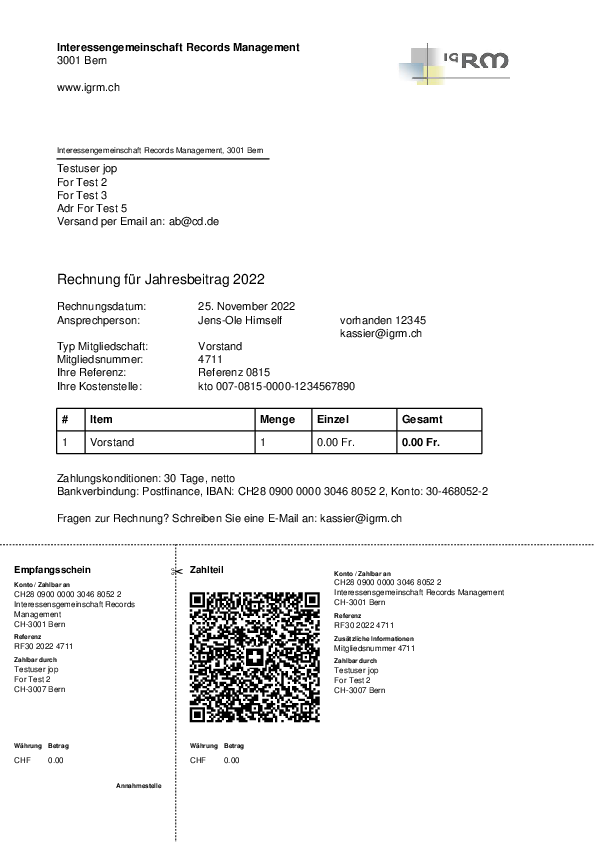

In [8]:
# Testlauf ohne Datenliste mit festen Beispielwerten

d = pd.Series(dtype = object)
d["Mitgliedsnummer"] = 4711
d["Mitgliedstyp"] = "Vorstand"
d["Strasse/Nr."] = "Musterstrasse 5" 
d["PLZ"] = "3007"
d["Ort"] = "Bern"
d["Rechnungsadresse 1"] = "Testuser jop"
d["Rechnungsadresse 2"] = "For Test 2"
d["Rechnungsadresse 3"] = "For Test 3"
d["Rechnungsadresse 4"] = np.nan
d["Rechnungsadresse 5"]  = "Adr For Test 5"
d["Ansprechperson"] = "Jens-Ole Himself"
d["Telefon"] = "vorhanden 12345"
d["E-Mail"] = "kassier@igrm.ch"
d["Referenz"] = "Referenz 0815"
d["Kostenstelle"] = "kto 007-0815-0000-1234567890"
d["E-Mail Rechnungsversand"] = "ab@cd.de"

target_fn = "IGRM_Mitgliedsrechnung_TEST_" + str(d["Mitgliedsnummer"])
generate_pdf(target_fn, d)
show_pdf( target_fn + ".pdf" )


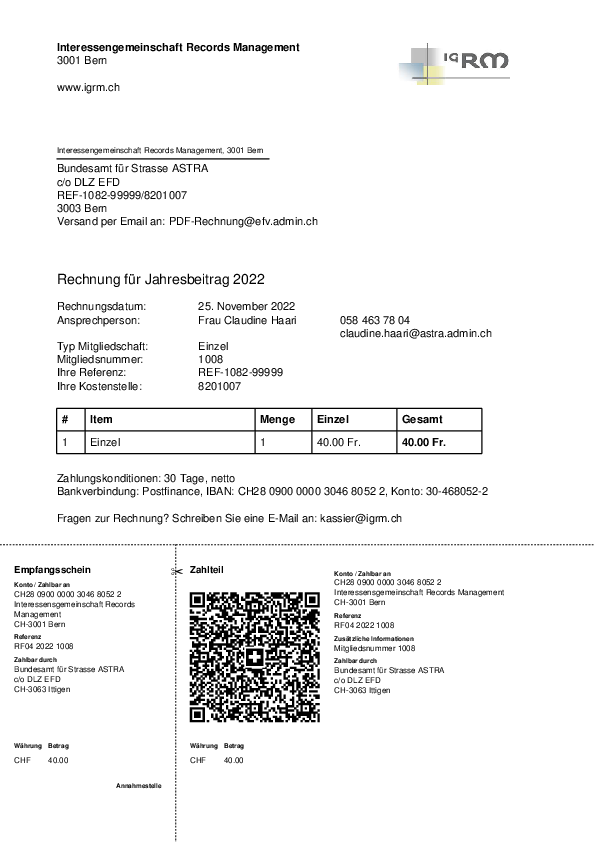

In [9]:
# Testlauf mit einem Datensatz aus der Mitgliederlsite 
q = liste.iloc[6]
target_fn = "IGRM_Mitgliedsrechnung_TEST_" + str(q["Mitgliedsnummer"])
generate_pdf(target_fn, q)
show_pdf( "IGRM_Mitgliedsrechnung_TEST_" + str(q["Mitgliedsnummer"]) + ".pdf" )

In [12]:
# Lauf mit allen Rechnungen
for i in range(len(liste)):

    d = liste.iloc[i]
    target_fn = "out/IGRM_Mitgliedsrechnung_" + str(d["Mitgliedsnummer"])
    generate_pdf(target_fn, d)
